# Section 3: Query Expansion

![Query Optimization](../images/query_optimization.png)

In this section, we're going to add one more step (purple) to our RAG pipeline. This is one of my favorite RAG techniques, where we re-write the user's query in different ways, and generate sample answers, before the retrieval step. This is helpful to augment our semantic search with different terms that the user may have ommitted.

We can then retrieve documents across these different queries, before aggregating these documents with a custom State Reducer.


## Setup

In [1]:
required_packages = [
    "langgraph", 
    "langgraph-sdk", 
    "langgraph-checkpoint-sqlite", 
    "langsmith", 
    "langchain-community", 
    "langchain-core", 
    "langchain-openai", 
    "notebook", 
    "python-dotenv", 
    "chromadb"
]

# Install each package
for package in required_packages:
    %pip install {package}

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

# Set environment variables
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph-101"

In [3]:
# Alternatively, load environment variables from .env
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env", override=True)

True

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

RAG_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.

Question: {question} 
Context: {context} 
Answer:"""

RAG_PROMPT_WITH_MESSAGES = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
The pre-existing conversation may provide important context to the question.
Use three sentences maximum and keep the answer concise.

Conversation: {conversation}
Context: {context} 
Answer:"""

# SiteMap loader
LANGGRAPH_DOCS = [
    "https://langchain-ai.github.io/langgraph/",
    "https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/",
    "https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/",
    "https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/",
    "https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/",
    "https://langchain-ai.github.io/langgraph/tutorials/rewoo/rewoo/",
    "https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler/",
    "https://langchain-ai.github.io/langgraph/concepts/high_level/",
    "https://langchain-ai.github.io/langgraph/concepts/low_level/",
    "https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/",
    "https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/",
    "https://langchain-ai.github.io/langgraph/concepts/multi_agent/",
    "https://langchain-ai.github.io/langgraph/concepts/persistence/",
    "https://langchain-ai.github.io/langgraph/concepts/streaming/",
    "https://langchain-ai.github.io/langgraph/concepts/faq/"
]

def get_vector_db_retriever():
    # Set embeddings
    embd = OpenAIEmbeddings()
    # Docs to index
    urls = LANGGRAPH_DOCS
    # Load
    docs = [WebBaseLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]
    # Split
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=200, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(docs_list)
    # Add to vectorstore
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=embd,
    )
    retriever = vectorstore.as_retriever(lambda_mult=0)
    return retriever

USER_AGENT environment variable not set, consider setting it to identify your requests.


Let's first copy over our code from our corrective RAG app! I've condensed the functions here for readability:

In [5]:
from langchain_openai import ChatOpenAI
from langchain.schema import Document
from typing import List
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field

# Fetch retriever
retriever = get_vector_db_retriever()

# Set up LLM
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# Define our GraphState, InputState, and OutputState
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        attempted_generations: the number of attempted generations
    """
    question: str
    generation: str
    documents: List[Document]
    attempted_generations: int

class InputState(TypedDict):
    """
    Represents the input state of our graph.

    Attributes:
        question: question
    """
    question: str

class OutputState(TypedDict):
    """
    Represents the final outputstate of our graph.

    Attributes:
        generation: LLM generation
        documents: list of documents
    """
    generation: str
    documents: List[Document]

# Define Nodes and Conditional Edges
def retrieve_documents(state: GraphState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE DOCUMENTS---")
    question = state["question"]
    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate_response(state: GraphState):
    """
    Generate response

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    attempted_generations = state.get("attempted_generations", 0)   # By default we set attempted_generations to 0 if it doesn't exist yet
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    # RAG generation
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {
        "question": question,
        "generation": generation,
        "attempted_generations": attempted_generations + 1   # In our state update, we increment attempted_generations
    }

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )
grade_documents_llm = llm.with_structured_output(GradeDocuments)
grade_documents_system_prompt = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_documents_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}"
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or to terminate execution.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---"
        )
        return "none relevant"    # same as END
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "some relevant"
    
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )
grade_hallucinations_llm = llm.with_structured_output(GradeHallucinations)
grade_hallucinations_system_prompt = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
grade_hallucinations_prompt = "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"
ATTEMPTED_GENERATION_MAX = 3
def grade_hallucinations(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    documents = state["documents"]
    generation = state["generation"]
    attempted_generations = state["attempted_generations"]

    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    grade_hallucinations_prompt_formatted = grade_hallucinations_prompt.format(
        documents=formatted_docs,
        generation=generation
    )

    score = grade_hallucinations_llm.invoke(
        [SystemMessage(content=grade_hallucinations_system_prompt)] + [HumanMessage(content=grade_hallucinations_prompt_formatted)]
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        return "supported"
    elif attempted_generations >= ATTEMPTED_GENERATION_MAX:    # New condition!
        print("---DECISION: TOO MANY ATTEMPTS, GIVE UP---")
        raise RuntimeError("Too many attempted generations with hallucinations, giving up.")
        # return "give up"    # Note: We could also do this to silently fail
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Query Expansion

The idea behind query expansion is that we want to augment the user's original query such that we can retrieve the most helpful documents possible from our document database. There are many techniques for this! Here are two that we'll employ today:
1. Re-writing the user's query a number of different ways and using each as a query to the vector DB
2. Leaning on the LLM's pre-training to generate some sample answers, and then using these sample answers to query the vector DB. (This is a favorite of mine, oftentimes, pre-training is good enough to approximate what an answer might look like, and that helps with semantic search)

In [6]:
from pydantic import BaseModel, Field

class RewrittenQueries(BaseModel):
    """Rewritten queries based on the user's original question."""
    rewritten_queries: List[str] = Field(
        description="A list of rewritten versions of the user's query. Each rewritten version is rewritten differently, rephrased and potentially uses synonyms."
    )

rewritten_query_llm = llm.with_structured_output(RewrittenQueries)
rewritten_query_system_prompt = """You are an analyst in charge of taking a user's question as input, and reframing and rewriting it in different ways.\n
Your goal is to change the phrasing of the question, while making sure that the intent and meaning of the question is the same.\n
Return a list of rewritten_queries. The number will be specified by the user."""
rewritten_query_prompt = "Here is the user's question: \n\n {question}. Return {num_rewrites} queries."

Let's test out our prompts on a question!

In [7]:
question = "Can I use LangGraph for customer support? I want to create an agent application."
num_rewrites = 3
rewritten_query_prompt_formatted = rewritten_query_prompt.format(question=question, num_rewrites=num_rewrites)
rewritten_query_llm.invoke(
    [SystemMessage(content=rewritten_query_system_prompt)] + [HumanMessage(content=rewritten_query_prompt_formatted)]
)

RewrittenQueries(rewritten_queries=['Is LangGraph suitable for developing a customer support agent application?', 'Can LangGraph be utilized to build an agent for customer support?', 'Is it possible to use LangGraph to create a customer support agent?'])

Now, let's write a prompt and structured output to generate a sample answer!

In [8]:
from pydantic import BaseModel, Field

class SampleAnswer(BaseModel):
    """Sample answer for an input question."""
    sample_answer: str = Field(
        description="A concise example answer for a question. This shouldn't exceed three sentences in length."
    )

sample_answer_llm = llm.with_structured_output(SampleAnswer)
sample_answer_system_prompt = """You are a novice in charge of taking a user's question as input, and generating a sample answer for it.\n
This sample answer should contain words that would likely be in a real answer, but is not grounded in any factual documents, the way a real answer would be."""
sample_answer_prompt = "Here is the user's question: \n\n {question}."

Let's test out our sample answer generator too

In [9]:
question = "Is it possible to utilize LangGraph for customer support? I'm looking to develop an agent application."
sample_answer_prompt_formatted = sample_answer_prompt.format(question=question)
sample_answer_llm.invoke(
    [SystemMessage(content=sample_answer_system_prompt)] + [HumanMessage(content=sample_answer_prompt_formatted)]
)

SampleAnswer(sample_answer='Yes, LangGraph can be utilized for customer support. It allows you to develop an agent application that can handle various customer queries efficiently. You can integrate it with your existing systems to provide a seamless support experience.')

Now, let's consider the scenario where we want to re-write the query and generate sample responses 3 times. This could be more effective in increasing the diversity of relevant documents we retrieve. 

However, running these four (3 new + original) sample answer generation + retrieval requests would increase the latency of this step in our pipeline by 4x as well.

At that point the latency of this step would outweigh the benefits. How can we circumvent this? By executing these sample answer generation steps in parallel!

### Parallelization

In order to learn about parallelization, let's look at a toy example unrelated to our RAG application.

We can define a simple graph with parallel node execution like so:

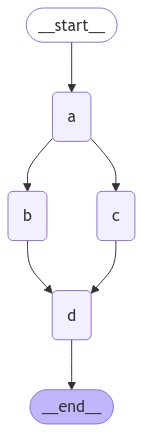

In [10]:
from typing import Any
from langgraph.graph import StateGraph
from langgraph.graph import START, END
from IPython.display import Image, display

class State(TypedDict):
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Here, nodes `b` and `c` would execute in parallel.

There is an issue however. Both of these nodes want to overwrite the same state key at the same time. Nodes `b` and `c` execute in the same super-step, and thus we have a conflicting update to node `d`.

How do we solve this? With a custom state reducer!

We add a custom state reducer to the `state` string field using `Annnotated`

In [11]:
import operator
from typing import Annotated

class State(TypedDict):
    state: Annotated[list, operator.add]

Now, we can handle multiple nodes flowing to a single aggregation node with multiple different state updates. We'll see this principle again in our RAG application.

One more note on parallelization: what happens in the case where one parallel path has more steps than the other one? 

LangGraph automatically handles this and waits for all of the parallel nodes in the longer path to finish.

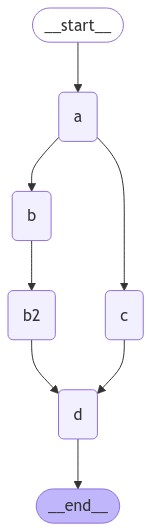

In [12]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In the above graph, `b`, `b2`, and `c` are all considered to be part of the same step. All of these will be completed before the graph progresses to node `d`.

### Performing Query Expansion in Parallel

Now that we understand parallel execution, let's add a node to generate three rewritten queries! We will also update our state to keep track of our rewritten queries.

In [13]:
class GraphState(TypedDict):
    question: str
    rewritten_queries: List[str]    # A new field to track our rewritten queries!
    generation: str
    documents: List[Document]
    attempted_generations: int


def generate_rewritten_queries(state):
    """
    Generates rewritten versions of the original user query

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates rewritten_queries key with a list of rewritten queries
    """
    print("---GENERATING REWRITTEN VERSIONS OF THE USER'S QUERY---")
    question = state["question"]
    num_rewrites = 3
    rewritten_query_prompt_formatted = rewritten_query_prompt.format(question=question, num_rewrites=num_rewrites)
    response = rewritten_query_llm.invoke(
        [SystemMessage(content=rewritten_query_system_prompt)] + [HumanMessage(content=rewritten_query_prompt_formatted)]
    )
    rewritten_queries = response.rewritten_queries

    return {"rewritten_queries": rewritten_queries}
    

Now, let's add our sample answer generation logic to our `retrieve_documents` node to further improve our semantic search!

In [14]:
def retrieve_documents(state):
    """
    Retrieve documents

    Args:
        state (dict): A dictionary containing a question

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE DOCUMENTS---")
    question = state["question"]
    sample_answer_prompt_formatted = sample_answer_prompt.format(question=question)
    response = sample_answer_llm.invoke(
        [SystemMessage(content=sample_answer_system_prompt)] + [HumanMessage(content=sample_answer_prompt_formatted)]
    )
    sample_answer = response.sample_answer
    documents = retriever.invoke(f"{question}: {sample_answer}")    # Now we use our question and sample answer
    return {"documents": documents}

Awesome, now we need to define edges from our new `generate_rewritten_queries` node to our `retrieve_documents` node. 

In contrast to earlier, we now need to create multiple edges (one for each rewritten query, and one for the original), and run each of these in parallel.

Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) function to dynamically create edges to the `retrieve_documents` node for each question that is generated, along with our original user's question.

This is very useful! It can automatically parallelize document retrieval (and sample answer generation) for any number of rewritten queries.

`Send` also allows you to pass any state that you want to `retrieve_documents`! It does not have to align with `OverallState`. In this case, we pass a different question to each `retrieve_documents` node.

In [15]:
from langgraph.constants import Send

def continue_to_retrieval_nodes(state: GraphState):
    edges_to_create = []
    # Add original question
    edges_to_create.append(Send("retrieve_documents", {"question": state["question"]}))
    # Add rewritten queries
    for rewritten_query in state["rewritten_queries"]:
        edges_to_create.append(Send("retrieve_documents", {"question": rewritten_query}))
    return edges_to_create

Now that we have multiple edges from the `retrieve_documents` node all updating the documents state, we need to make sure that we add a custom state reducer to handle the update. Our functionality here needs to be pretty specific.

- Case 1: When the `retrieve_documents` nodes update the documents state, we will simply want to add all of the documents to the list. 
- Case 2: However, when the `grade_documents` node later filters down to documents that pass our LLM-as-judge relevance test, we still will want to perform a total overwrite. 

Separately, we will also want to add some logic to the `grade_documents` node that filters down all of our retrieved documents to the most frequently retrieved documents, and only bother grading those (in order to save us some work).

Let's write a custom reducer, and then update our logic in the `grade_documents` node.

In [16]:
def custom_documents_reducer(existing, update):
    # If we passed in a dictionary that asks for "overwrite", then we return the updated documents only
    if isinstance(update, dict) and update["type"] == "overwrite":
        return update["documents"]

    # Otherwise, we simple add the lists
    return existing + update

class GraphState(TypedDict):
    question: str
    rewritten_queries: List[str]
    generation: str
    documents: Annotated[List[Document], custom_documents_reducer]   # We use Annotated to add our custom reducer
    attempted_generations: int

In [17]:
from collections import Counter

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # -- New logic to deduplicate documents our queries --
    doc_counter = Counter(doc.page_content for doc in documents)
    most_common_contents = doc_counter.most_common(5)
    top_documents = []
    for content, _ in most_common_contents:
        for d in documents:
            if d.page_content == content:
                top_documents.append(d)
                break

    # Score each one of our five most common documents
    filtered_docs = []
    for d in top_documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": {"type": "overwrite", "documents": filtered_docs}, "question": question}

Wow, we just added a lot of features to our graph. Let's review them as we build our graph!

1. We added a new `generate_rewritten_queries` node that generates three rewritten versions of the user's original query
2. This node makes use of `Send` to dynamically create multiple edges to our `retrieve_documents` node
3. Our `retrieve_documents` node now generates a `sample_answer` for the passed in query, to improve the power of our semantic search
4. We wrote a custom reducer for `documents`, so that when our `retrieve_documents` node outputs new documents, they are added to a master list along with the documents from all of the other queries. However, when our `grade_documents` node outputs a filtered down relevant list, we still overwrite our graph state.
5. Our `grade_documents` node deduplicates common documents passed in from our `retrieve_documents` nodes, and we only grade the top 5 documents for relevance

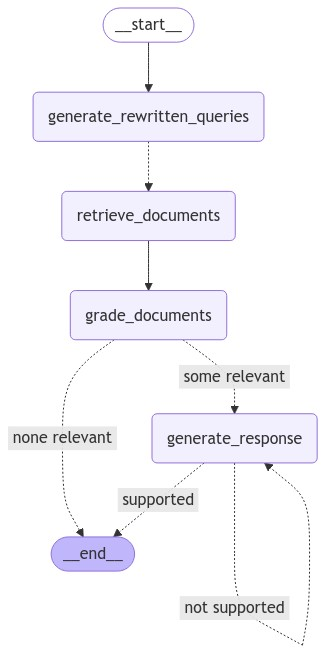

In [18]:
graph_builder = StateGraph(GraphState, input=InputState, output=OutputState)
graph_builder.add_node("generate_rewritten_queries", generate_rewritten_queries)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)

graph_builder.add_edge(START, "generate_rewritten_queries")
graph_builder.add_conditional_edges(
    "generate_rewritten_queries",
    continue_to_retrieval_nodes,
    ["retrieve_documents"]
)
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": END,
        "not supported": "generate_response"
    })

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Let's watch how this works!

In [19]:
question = "Can I use LangGraph for customer support? I want to create an agent application."
graph.invoke({"question": question})

---GENERATING REWRITTEN VERSIONS OF THE USER'S QUERY---
---RETRIEVE DOCUMENTS------RETRIEVE DOCUMENTS---

---RETRIEVE DOCUMENTS---
---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---


{'generation': AIMessage(content='Yes, you can use LangGraph to create a customer support agent application. LangGraph provides tools and features such as interrupts, checkpointers, and human-in-the-loop patterns to build reliable and efficient customer support bots. It allows for customization of agent architectures and supports parallel processing for handling complex tasks.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 639, 'total_tokens': 699, 'completion_tokens_details': {'reasoning_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_2f406b9113', 'finish_reason': 'stop', 'logprobs': None}, id='run-40374f40-94ce-4e8b-a133-2fe1fcdca195-0', usage_metadata={'input_tokens': 639, 'output_tokens': 60, 'total_tokens': 699}),
 'documents': [Document(metadata={'description': 'Build language agents as graphs', 'language': 'en', 'source': 'https://langcha

Cool! We see we generate rewritten version of the query. Then we retrieve documents for each of those queries, and then we grade the top 5 most documents.

__Let's take a look in LangGraph Studio__